<center><h1>CNN 多通道情感分析</h1></center>

一个有三个通道，分别是word embedding，POS 标签 embedding, 词的情感极性强度embedding

In [1]:
import keras 
from  os.path import join
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, Lambda,Input
from keras.layers import Embedding
from keras.layers import Convolution1D
from keras.datasets import imdb
from keras import backend as K
from keras.layers import Convolution1D, GlobalMaxPooling1D,Convolution2D,Merge,merge
from keras.utils import np_utils
from keras.models import Model
import nltk
from nltk.tag import pos_tag
import numpy as np
from keras.regularizers import l2
import theano

Using Theano backend.
Using gpu device 0: GeForce GT 630 (CNMeM is disabled, cuDNN not available)


## POS当作一个通道。


Tag word 的方法： http://www.nltk.org/book/ch05.html

In [2]:
file_names = ['stsa.fine.test','stsa.fine.train','stsa.fine.dev']
file_path = '/home/bruce/data/sentiment/citai_process'
def read_file(fname=''):
    with open(join(file_path,fname)) as fr:
        lines = fr.readlines()
    lines = [line.strip().lower() for line in lines]
    lables = [int(line[0:1]) for line in lines]
    words = [line[2:].split() for line in lines]
    return words,lables       
train_X,train_y = read_file(fname='stsa.fine.train')
test_X,test_y = read_file(fname='stsa.fine.test')
dev_X,dev_y = read_file(fname='stsa.fine.dev')
print(len(train_X))
print(len(test_X))
print(len(dev_X))
print(train_X[0:2])
print(train_y[0:2])


8544
2210
1101
[['a', 'stirring', ',', 'funny', 'and', 'finally', 'transport', 're-imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', '1930s', 'horror', 'film'], ['apparently', 'reassemble', 'from', 'the', 'cutting-room', 'floor', 'of', 'any', 'give', 'daytime', 'soap', '.']]
[4, 1]


In [3]:
def tag_sentence(X=[]):
    tag_X=[]
    for line in X:
        word_tag = pos_tag(line,tagset='universal')
        tag = [i[1] for i in word_tag]
        tag_X.append(tag)
    return tag_X
train_tag_X = tag_sentence(X=train_X)
dev_tag_X = tag_sentence(X=dev_X)
test_tag_X = tag_sentence(X=test_X)
print(train_X[0])
print(train_tag_X[0])

['a', 'stirring', ',', 'funny', 'and', 'finally', 'transport', 're-imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', '1930s', 'horror', 'film']
['DET', 'NOUN', '.', 'ADJ', 'CONJ', 'ADV', 'VERB', 'NOUN', 'ADP', 'NOUN', 'CONJ', 'DET', 'NOUN', 'CONJ', 'NUM', 'NOUN', 'NOUN']


## 情感极性当作一个通道。


#### 读取情感强度文件，构建字典

In [4]:
senti_file = '/home/bruce/data/sentiment/sentiment_diction/wordwithStrength.txt'
def construct_senti_dict(senti_file=''):
    with open(senti_file) as fr:
        lines = fr.readlines()
    lines = [line.strip().split() for line in lines]
    lines = [(i[0],float(i[1])) for i in lines]
    return dict(lines)
sentiment_dict=construct_senti_dict(senti_file)
print('sentiment number =',len(sentiment_dict))

sentiment number = 18540


#### 构建情感极性强度通道

In [5]:
def sentiment_strength(X=[],sentiment_dict=sentiment_dict):
    sentiment_X = [[sentiment_dict[w] if w in sentiment_dict else 0 for w in line ]for line in X]
    sentiment_X = [[ str(int(val*10)) if val <=0 else  '+'+str(int(val*10)) for val in line] for line in sentiment_X]
    return sentiment_X
train_sentiment_X = sentiment_strength(X=train_X,sentiment_dict=sentiment_dict)
dev_sentiment_X = sentiment_strength(X=dev_X,sentiment_dict=sentiment_dict)
test_sentiment_X = sentiment_strength(X=test_X,sentiment_dict=sentiment_dict)

assert len(train_sentiment_X) == len(train_X) 
print(train_sentiment_X[0:5])
print(train_X[0:5])    
print(train_y[0:5])


[['0', '+4', '0', '0', '0', '0', '0', '0', '0', '+2', '0', '0', '-5', '0', '0', '-2', '0'], ['+5', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], ['0', '-5', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '+6', '-2', '0', '+2', '0', '0', '-3', '0', '0', '0', '-5', '0', '0', '0', '0', '0', '0', '0', '-2', '0', '0'], ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], ['0', '0', '0', '+5', '-2', '0', '+2', '+3', '0', '0', '0', '0', '0', '0', '-3', '0', '+2', '0', '0', '0']]
[['a', 'stirring', ',', 'funny', 'and', 'finally', 'transport', 're-imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', '1930s', 'horror', 'film'], ['apparently', 'reassemble', 'from', 'the', 'cutting-room', 'floor', 'of', 'any', 'give', 'daytime', 'soap', '.'], ['they', 'presume', 'their', 'audience', 'wo', "n't", 'sit', 'still', 'for', 'a', 'sociology', 'lesson', ',', 'however', 'entertainingly', 'present', ',', 'so', 'they', 'trot', 'out', 'the', 'conventional', 'science-fiction', 'eleme

## 否定词。

1.资料：http://web.stanford.edu/~cgpotts/papers/potts-salt20-negation.pdf

2.Negation handing in NLP  http://stackoverflow.com/questions/28720174/negation-handling-in-nlp

#### 数据预处理

In [6]:
def token_to_index(datas=[]):
    word_index={}
    count=1
    for data in datas:
        for list_ in data:
            for w in list_:
                if w not in word_index:
                    word_index[w] = count
                    count = count + 1
    print('leng of word_index =',len(word_index))
    for i in range(len(datas)):
        datas[i] = [[ word_index[w] for w in line ] for line in datas[i]] 
    return datas,word_index
X,word_index = token_to_index(datas=[train_X,dev_X,train_sentiment_X,train_tag_X,dev_sentiment_X,dev_tag_X])
train_X,dev_X,train_sentiment_X,train_tag_X,dev_sentiment_X,dev_tag_X = X

print('length of dict_index = ',len(word_index))


leng of word_index = 14525
length of dict_index =  14525


In [7]:
print(train_sentiment_X[0:2])
print(train_X[0:2])    
print(train_y[0:2])

[[14498, 14499, 14498, 14498, 14498, 14498, 14498, 14498, 14498, 14500, 14498, 14498, 14501, 14498, 14498, 14502, 14498], [14503, 14498, 14498, 14498, 14498, 14498, 14498, 14498, 14498, 14498, 14498, 14498]]
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 5, 11, 12, 5, 13, 14, 15], [16, 17, 18, 11, 19, 20, 9, 21, 22, 23, 24, 25]]
[4, 1]


## Glove训练好的词向量

#### 利用glove基于twitter训练公开的数据

In [8]:
embedding_dim = 100
we_file = '/home/bruce/data/glove/twitter/glove.twitter.27B.{0}d.txt'.format(embedding_dim)
def get_index_wordembedding(we_file='',word_index={}):
    index_wordembedding ={}
    zeros = np.zeros(embedding_dim)
    for line in open(we_file):
        elements = line.strip().split()
        if elements[0] in  word_index:
            index = word_index[elements[0]]
            wordembedding = [float(i) for i in elements[1:]]
            index_wordembedding[index] = wordembedding
    print('总word的数目= ',len(word_index))
    print('总word embedding 的数目 = ',len(index_wordembedding))
    
    for word,index in word_index.items():
        if index not in index_wordembedding:
            index_wordembedding[index] = zeros
    assert len(index_wordembedding) == len(word_index)
    return index_wordembedding
index_wordembedding = get_index_wordembedding(we_file=we_file,word_index=word_index)

总word的数目=  14525
总word embedding 的数目 =  11850


#### 获取训练好的word embedding 数组，用来初始化 Embedding 

In [9]:
def get_trained_embedding(index_wordembedding=None):
    index_we = sorted(index_wordembedding.items())
    print('index_we[0] =',index_we[0])
    trained_embedding = [t[1] for t in index_we]
    zeros = np.zeros(embedding_dim)
    trained_embedding = np.vstack((zeros,trained_embedding))
    return np.array(trained_embedding)
    

#### 将一个batch大小的index数据，利用index_wordembedding进行embedding

In [10]:
def batch_indexData_embedding(X=None,index_wordembedding={}):
    zeros = np.zeros(embedding_dim)
    return [ [ index_wordembedding[w] if w in index_wordembedding else zeros  for w in line ] for line in X ]

## 构建模型

#### 模型参数

In [11]:
max_len = 36
batch_size=50

max_features= 14526
#embedding_dims=50

nb_filter = 100
filter_length1 = 3
filter_length2 = 4
filter_length3 = 5
dense1_hindden = 150*2
nb_classes = 5

## 错误记录

1.输入的变量和后面同名

## CNN -Rand 模型

In [29]:
print('Build model...')
input_random = Input(shape=(max_len,), dtype='int32', name='main_input1')
embedding = Embedding(output_dim=embedding_dim, input_dim=max_features)(input_random)
# 卷积层
conv1 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length1,
                        border_mode = 'valid',
                        activation='relu'
                       )(embedding)
conv2 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length1,
                        border_mode = 'valid',
                        activation='relu'
                       )(embedding)

conv3 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length1,
                        border_mode = 'valid',
                        activation='relu'
                       )(embedding)
conv1 =GlobalMaxPooling1D(conv1)
conv2 =GlobalMaxPooling1D()(conv2)
conv3 =GlobalMaxPooling1D()(conv3)
merged_vector = merge([conv1,conv2,conv3], mode='concat')
# 全连接层
dense_layer = Dense(dense1_hindden)
dens1 = dense_layer(merged_vector)
print('dense_layer input_shape should == (300,)')
print(dense_layer.input_shape)
dens1 = Activation('relu')(dens1)

# softmax层
dens2 = Dense(nb_classes)(dens1)
output_random = Activation('softmax')(dens2)

model = Model(input=input_random,output=output_random)
print('finish build model')
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Build model...
(None, 100)
dense_layer input_shape should == (300,)
(None, 300)
finish build model


## CNN-static 模型

In [12]:
input_static = Input(shape=(max_len,embedding_dim), name='main_input2')
# 卷积层
conv1 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length1,
                        border_mode = 'valid',
                        activation='relu'
                       )(input_static)

conv2 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length1,
                        border_mode = 'valid',
                        activation='relu'
                       )(input_static)

conv3 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length1,
                        border_mode = 'valid',
                        activation='relu'
                       )(input_static)
conv1 =GlobalMaxPooling1D()(conv1)
conv2 =GlobalMaxPooling1D()(conv2)
conv3 =GlobalMaxPooling1D()(conv3)
merged_vector = merge([conv1,conv2,conv3], mode='concat')

# 全连接层
dens1 = Dense(dense1_hindden)(merged_vector)
dens1 = Activation('relu')(dens1)

# softmax层
dens2 = Dense(nb_classes)(dens1)
output_static = Activation('softmax')(dens2)

model = Model(input=input_static,output=output_static)
print('finish build model')
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


finish build model


## CNN-non-static 模型

In [32]:
print('Build model...')
input_non_static = Input(shape=(max_len,), dtype='int32', name='main_input1')
#初始化Embedding层
trained_embedding = get_trained_embedding(index_wordembedding=index_wordembedding)

embedding_layer = Embedding(max_features,
                            embedding_dim,
                            weights=[trained_embedding]
                            )

embedding = embedding_layer(input_non_static)

conv1 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length1,
                        border_mode = 'valid',
                        activation='relu'
                       )(embedding)

conv2 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length1,
                        border_mode = 'valid',
                        activation='relu'
                       )(embedding)

conv3 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length1,
                        border_mode = 'valid',
                        activation='relu'
                       )(embedding)
dropout = Dropout(0.5)

conv1 =GlobalMaxPooling1D()(conv1)
conv2 =GlobalMaxPooling1D()(conv2)
conv3 =GlobalMaxPooling1D()(conv3)
#conv1 = dropout(conv1)
#conv2 = dropout(conv2)
#conv3 = dropout(conv3)

merged_vector = merge([conv1,conv2,conv3], mode='concat')
# 全连接层
dense_layer = Dense(dense1_hindden)
dens1 = dense_layer(merged_vector)
print('dense_layer input shpae = ',dense_layer.input_shape)
dens1 = Activation('relu')(dens1)
dens1 = dropout(dens1)

# softmax层
dens2 = Dense(nb_classes)(dens1)
output_non_static = Activation('softmax')(dens2)

model = Model(input=input_non_static,output=output_non_static)
print('finish build model')
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Build model...
index_we[0] = (1, [0.86323, 0.031356, 0.10169, 0.26639, 0.19313, -0.076727, -0.22647, -0.69596, -0.63946, -0.8632, -0.29465, -0.31175, -4.4257, -0.16769, 0.23197, -0.0085179, -0.063032, -0.044064, -0.23138, 0.59465, -0.1334, -0.61637, -0.019008, -0.31235, -0.2403, -3.112, 0.22267, -0.046524, -0.046095, 1.1434, 0.60818, 0.34767, 0.36155, 0.35258, -0.16617, 0.82837, 0.35088, -0.23608, -0.25425, 0.55587, -1.4276, 0.06918, 0.015027, -0.45487, 0.63978, -0.16407, 0.14985, 0.94771, 0.23274, -0.51445, 0.70982, 0.60018, 0.047234, -0.39084, -0.14794, 0.68263, -0.12995, -0.22846, 0.43185, -0.10681, 0.06544, 0.34506, 0.089428, 0.19983, 1.1775, -0.33236, -0.60181, 0.38324, -0.090755, -0.15759, -0.23093, -0.88441, 0.07837, 0.19774, -0.10609, 0.28091, 0.14899, -0.224, 0.20039, -0.23564, 1.5186, 0.3518, -0.10327, -0.14035, 0.084164, 0.76701, -0.54544, 0.17372, -0.02784, 0.4905, 0.45353, 0.13881, 0.091135, 0.31961, -0.077948, 0.045671, -0.55133, -0.28853, -0.50833, -0.31382])
dense_layer

## CNN-multichannel 模型

In [ ]:
print('Build model...')
input1 = Input(shape=(max_len,), dtype='int32', name='main_input1')
input2 = Input(shape=(max_len,embedding_dim), name='main_input2')
#input3 = Input(shape=(max_len,), dtype='int32', name='main_input3')

embedding = Embedding(output_dim=embedding_dim, input_dim=max_features)
embedding1 = embedding(input1)
#embedding2 = embedding(input2)
#embedding3 = embedding(input3)
#---------------------------------------------------------------------------
#卷积方法一：每个通道，用不同的卷积核
'''
cov1_out1 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length,
                        border_mode = 'valid',
                        activation='relu'
                       )(embedding1)
cov1_out2 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length,
                        border_mode = 'valid',
                        activation='relu'
                       )(embedding2)
cov1_out3 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length,
                        border_mode = 'valid',
                        activation='relu'
                       )(embedding3)
'''
# 卷积方法二：每个通道用相同的卷积核
conv11 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length1,
                        border_mode = 'valid',
                        activation='relu',
                        W_regularizer=l2(3)
                       )
conv12 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length2,
                        border_mode = 'valid',
                        activation='relu',
                        W_regularizer=l2(3)
                       )
conv13 = Convolution1D(nb_filter = nb_filter,
                        filter_length = filter_length3,
                        border_mode = 'valid',
                        activation='relu',
                        W_regularizer=l2(3)
                       )
dropout = Dropout(0.5)
#第一个通道
cov1_out11  = conv11(embedding1)
cov1_out12  = conv12(embedding1)
cov1_out13  = conv13(embedding1)
cov1_out11 = dropout(cov1_out11)
cov1_out12 = dropout(cov1_out12)
cov1_out13 = dropout(cov1_out13)

#第二个通道
cov1_out14 = conv11(input2)
cov1_out15 = conv12(input2)
cov1_out16 = conv13(input2)
cov1_out14 = dropout(cov1_out14)
cov1_out15 = dropout(cov1_out15)
cov1_out16 = dropout(cov1_out16)
#cov1_out2 = conv(embedding2)
#cov1_out3 = conv(embedding3)

#------------------------------------------------------------------------------
maxpooling = GlobalMaxPooling1D()
conv11 = maxpooling(cov1_out11)
conv12 = maxpooling(cov1_out12)
conv13 = maxpooling(cov1_out13)
conv14 = maxpooling(cov1_out14)
conv15 = maxpooling(cov1_out15)
conv16 = maxpooling(cov1_out16)

merged_vector = merge([conv11,conv12,conv13,conv14,conv15,conv16], mode='concat')

#dropout = Dropout(0.5)
#merged_vector = dropout(merged_vector)

dens1 = Dense(dense1_hindden)(merged_vector)
dens1 = Activation('relu')(dens1)


dens2 = Dense(nb_classes)(dens1)
output = Activation('softmax')(dens2)
model = Model(input=[input1,input2],output=output)

print('finish build model')
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 模型图

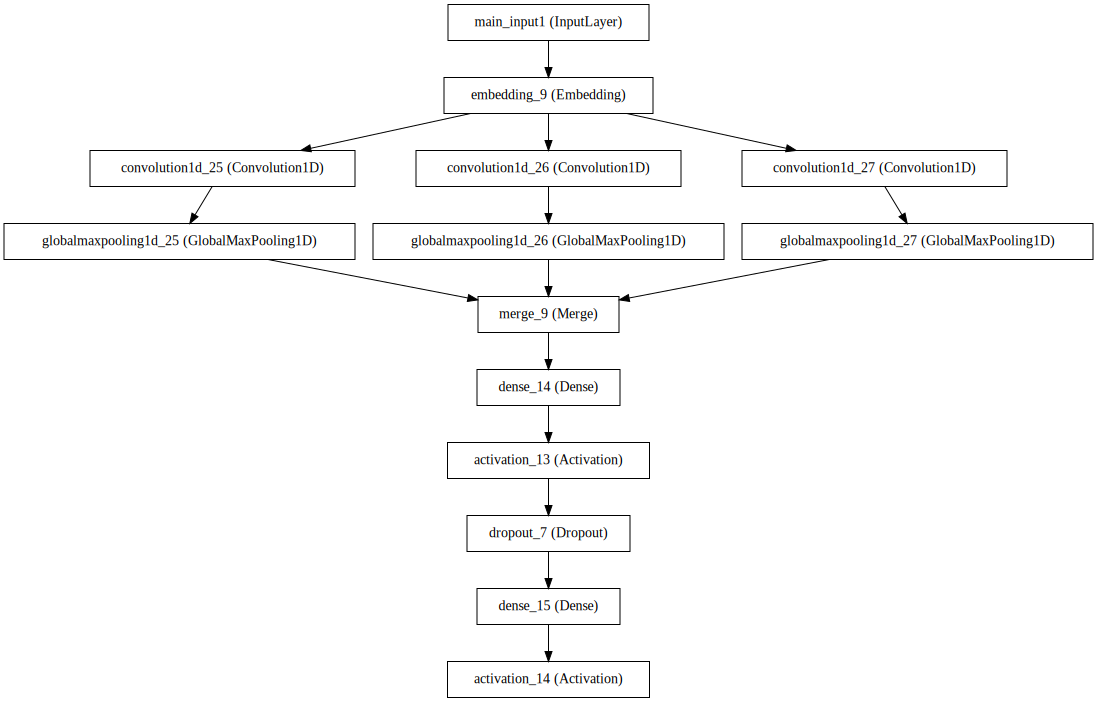

In [33]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 模型输入

In [14]:
print(type(train_y[0]))
train_y_model = np_utils.to_categorical(train_y, nb_classes)
dev_y_model = np_utils.to_categorical(dev_y, nb_classes)
train_X_model = sequence.pad_sequences(train_X, maxlen=max_len)
dev_X_model = sequence.pad_sequences(dev_X, maxlen=max_len)
train_sentiment_X_model = sequence.pad_sequences(train_sentiment_X,maxlen=max_len)
train_tag_X_model= sequence.pad_sequences(train_tag_X,maxlen=max_len)
dev_sentiment_X_model = sequence.pad_sequences(dev_sentiment_X,maxlen=max_len)
dev_tag_X_model = sequence.pad_sequences(dev_tag_X,maxlen=max_len)
#train_embedding_X_model = batch_indexData_embedding(X=train_X_model,index_wordembedding=index_wordembedding)
dev_embedding_X_model = batch_indexData_embedding(X=dev_X_model,index_wordembedding=index_wordembedding)
dev_embedding_X_model = np.array(dev_embedding_X_model)


<class 'int'>


#### 测试数据

In [15]:
#转为index 
def to_index(word_index={},data=[]):
    return [[word_index[w] if w in word_index else 0  for w in sentence] for sentence in data]
test_index_X = to_index(word_index,test_X)
#删补
test_index_X = sequence.pad_sequences(test_index_X, maxlen=max_len)
#embedding
test_embedding_X = batch_indexData_embedding(X=test_index_X,index_wordembedding=index_wordembedding)
test_y = np_utils.to_categorical(test_y, nb_classes)

In [16]:
def my_generator4(X1=None,X2=None,X3=None,x4=None,y=None):
    i = 0
    max_i = int(len(X1)/batch_size)
    while True:
        i = i % max_i
        x1_batch = X1[i*batch_size:(i+1)*batch_size]
        x2_batch = X2[i*batch_size:(i+1)*batch_size]
        x3_batch = X3[i*batch_size:(i+1)*batch_size]
       
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield ([x1_batch,x2_batch,x3_batch],y_batch)
        i = i + 1
def my_generator3(X1=None,y=None):
    i = 0
    max_i = int(len(X1)/batch_size)
    while True:
        i = i % max_i
        x1_batch = X1[i*batch_size:(i+1)*batch_size]
        x2_batch = batch_indexData_embedding(X=x1_batch,index_wordembedding=index_wordembedding)
        x2_batch = np.array(x2_batch)
       
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield ([x1_batch,x2_batch],y_batch)
        i = i + 1
def my_generator1(X1=None,y=None):
    i = 0
    max_i = int(len(X1)/batch_size)
    while True:
        i = i % max_i
        x1_batch = X1[i*batch_size:(i+1)*batch_size]
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield (x1_batch,y_batch)
        i = i + 1
def my_generator2(X1=None,y=None):
    i = 0
    max_i = int(len(X1)/batch_size)
    while True:
        i = i % max_i
        x1_batch = X1[i*batch_size:(i+1)*batch_size]
        x1_batch = batch_indexData_embedding(X=x1_batch,index_wordembedding=index_wordembedding)
        x1_batch = np.array(x1_batch)
       
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield (x1_batch,y_batch)
        i = i + 1

## 训练模型

#### cnn random 模型

In [26]:
model.fit_generator(my_generator1(train_X_model,train_y_model),samples_per_epoch = 32*100,nb_epoch=100,verbose=1,validation_data=(dev_X_model,dev_y_model))

Epoch 1/100
3200/3200 [==============================] - 141s - loss: 1.5767 - acc: 0.2703 - val_loss: 1.5712 - val_acc: 0.2525
Epoch 2/100
3200/3200 [==============================] - 141s - loss: 1.5596 - acc: 0.2778 - val_loss: 1.5728 - val_acc: 0.2598
Epoch 3/100
3200/3200 [==============================] - 141s - loss: 1.5658 - acc: 0.2894 - val_loss: 1.5655 - val_acc: 0.3061
Epoch 4/100
3200/3200 [==============================] - 141s - loss: 1.5466 - acc: 0.2975 - val_loss: 1.5611 - val_acc: 0.3025
Epoch 5/100
3200/3200 [==============================] - 141s - loss: 1.5434 - acc: 0.3028 - val_loss: 1.5446 - val_acc: 0.3052
Epoch 6/100
3200/3200 [==============================] - 141s - loss: 1.5209 - acc: 0.3100 - val_loss: 1.5319 - val_acc: 0.3252
Epoch 7/100
3200/3200 [==============================] - 141s - loss: 1.5031 - acc: 0.3316 - val_loss: 1.5104 - val_acc: 0.3442
Epoch 8/100
3200/3200 [==============================] - 141s - loss: 1.4846 - acc: 0.3466 - val_loss: 1

KeyboardInterrupt: 

#### cnn random 结果

|time            |max_len      | batch_size   |  max_features | embedding_dims | nb_filter | filter_length | dense1_hindden |val_acc |
| -             |-          |-          |-          |-           |-       |-         | -          |-     | 
| 2016-11-25 9：52  |36          |50        | 14526       |   100      |  各100    |     3,4,5    |      300   | 0.4169|



#### cnn static 模型

In [17]:
model.fit_generator(my_generator2(train_X_model,train_y_model),samples_per_epoch = 32*100,nb_epoch=100,verbose=1,validation_data=(test_embedding_X,test_y))

Epoch 1/100
3200/3200 [==============================] - 7s - loss: 1.5584 - acc: 0.2828 - val_loss: 1.5444 - val_acc: 0.2643
Epoch 2/100
3200/3200 [==============================] - 7s - loss: 1.4847 - acc: 0.3403 - val_loss: 1.4650 - val_acc: 0.3371
Epoch 3/100
3200/3200 [==============================] - 7s - loss: 1.4243 - acc: 0.3666 - val_loss: 1.3837 - val_acc: 0.3986
Epoch 4/100
3200/3200 [==============================] - 7s - loss: 1.3394 - acc: 0.4072 - val_loss: 1.3730 - val_acc: 0.4000
Epoch 5/100
3200/3200 [==============================] - 7s - loss: 1.3169 - acc: 0.4359 - val_loss: 1.3482 - val_acc: 0.3896
Epoch 6/100
3200/3200 [==============================] - 7s - loss: 1.2558 - acc: 0.4484 - val_loss: 1.3557 - val_acc: 0.3792
Epoch 7/100
3200/3200 [==============================] - 7s - loss: 1.2113 - acc: 0.4834 - val_loss: 1.3742 - val_acc: 0.3471
Epoch 8/100
3200/3200 [==============================] - 7s - loss: 1.2069 - acc: 0.4903 - val_loss: 1.5117 - val_acc:

#### cnn static 结果

|time            |max_len      | batch_size   |  max_features | embedding_dims | nb_filter | filter_length | dense1_hindden |val_acc |
| -             |-          |-          |-          |-           |-       |-         | -          |-     | 
| 2016-11-25 9：52  |36          |50        | 14526       |   100      |  各100    |     3,4,5    |      300   | 0.4253|


#### cnn non-static 模型

In [34]:
model.fit_generator(my_generator1(train_X_model,train_y_model),samples_per_epoch = 50*40,nb_epoch=100,verbose=1,validation_data=(test_index_X,test_y))

Epoch 1/100
2000/2000 [==============================] - 6s - loss: 1.6160 - acc: 0.2560 - val_loss: 1.5496 - val_acc: 0.3081
Epoch 2/100
2000/2000 [==============================] - 6s - loss: 1.5724 - acc: 0.2760 - val_loss: 1.5286 - val_acc: 0.3308
Epoch 3/100
2000/2000 [==============================] - 6s - loss: 1.5372 - acc: 0.3175 - val_loss: 1.5180 - val_acc: 0.3290
Epoch 4/100
2000/2000 [==============================] - 6s - loss: 1.5177 - acc: 0.3265 - val_loss: 1.4710 - val_acc: 0.3719
Epoch 5/100
2000/2000 [==============================] - 6s - loss: 1.4547 - acc: 0.3760 - val_loss: 1.4388 - val_acc: 0.3661
Epoch 6/100
2000/2000 [==============================] - 6s - loss: 1.4269 - acc: 0.3660 - val_loss: 1.4374 - val_acc: 0.3665
Epoch 7/100
2000/2000 [==============================] - 6s - loss: 1.4063 - acc: 0.3870 - val_loss: 1.3889 - val_acc: 0.3977
Epoch 8/100
2000/2000 [==============================] - 6s - loss: 1.4010 - acc: 0.3950 - val_loss: 1.3765 - val_acc:

#### cnn non-static 结果

|time            |max_len      | batch_size   |  max_features | embedding_dims | nb_filter | filter_length | dense1_hindden |val_acc |
| -             |-          |-          |-          |-           |-       |-         | -          |-     | 
| 2016-11-25 9：52  |36          |50        | 14526       |   100      |  各100    |     3,4,5    |      300   | 0.4204|
| 2016-11-26 9：52  |36          |50        | 14526       |   100      |  各100    |     3,4,5    |      300   | 0.4471|


In [61]:
model.fit_generator(my_generator(train_X_model,train_sentiment_X_model,train_tag_X_model,train_y_model),samples_per_epoch = 32*100,nb_epoch=100,verbose=1,validation_data=([dev_X_model,dev_sentiment_X_model,dev_tag_X_model],dev_y_model))

Epoch 1/100
3200/3200 [==============================] - 334s - loss: 1.5742 - acc: 0.2650 - val_loss: 1.5627 - val_acc: 0.2598
Epoch 2/100
3200/3200 [==============================] - 334s - loss: 1.5498 - acc: 0.2972 - val_loss: 1.5499 - val_acc: 0.3124
Epoch 3/100
3200/3200 [==============================] - 334s - loss: 1.5352 - acc: 0.3137 - val_loss: 1.5339 - val_acc: 0.3152
Epoch 4/100
3200/3200 [==============================] - 334s - loss: 1.5132 - acc: 0.3184 - val_loss: 1.5171 - val_acc: 0.3233
Epoch 5/100
3200/3200 [==============================] - 334s - loss: 1.4971 - acc: 0.3325 - val_loss: 1.5003 - val_acc: 0.3261
Epoch 6/100
3200/3200 [==============================] - 334s - loss: 1.4634 - acc: 0.3466 - val_loss: 1.4700 - val_acc: 0.3397
Epoch 7/100
3200/3200 [==============================] - 333s - loss: 1.4384 - acc: 0.3625 - val_loss: 1.4501 - val_acc: 0.3433
Epoch 8/100
3200/3200 [==============================] - 334s - loss: 1.4194 - acc: 0.3750 - val_loss: 1

## 实验结果 

|time            |max_len      | batch_size   |  max_features | embedding_dims | nb_filter | filter_length | dense1_hindden |val_acc |
| -             |-          |-          |-          |-           |-       |-         | -          |-     | 
| 2016-11-23 14：20  |36          |32         | 14526       |   200      |  50    |     2    |       300   | 0.4015|
| 2016-11-24 11：16  |36          |32         | 14526       |  200        | 150     |   2      |      300   | 0.4142 | 


#### 两通道实验结果，一个是用训练好的词向量初始化句子，另一个是用随机初始化的词向量初始化句子。

|time            |max_len      | batch_size   |  max_features | embedding_dims | nb_filter | filter_length | dense1_hindden |val_acc |
| -             |-          |-          |-          |-           |-       |-         | -          |-     | 
| 2016-11-25 9：52  |36          |32         | 14526       |   100      |  各100    |     3,4,5    |       300   | 0.4124|

